In [1]:
# !pip install kaggle
# !kaggle datasets download -p dataset/ --unzip cpanag/aifloodsense

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from torch import nn
from tqdm import tqdm
from torchmetrics import JaccardIndex
import albumentations as A
import cv2

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
classes_info = pd.DataFrame({
    'class': ['background', 'flood', 'sky', 'building'],
    'grayscale_value': [0, 255, 170, 85],
    'class_index': [0, 1, 2, 3]
})

classes_info

,class,grayscale_value,class_index
0,background,0,0
1,flood,255,1
2,sky,170,2
3,building,85,3


In [5]:
TRAIN_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'images')
TRAIN_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'masks')
VAL_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'images')
VAL_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'masks')

In [6]:
for image_name in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
    mask_name = image_name.split('.')[0] + '.png'
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

image_path, mask_path

('dataset/AIFloodSense/AIFloodSense/train/images/157.jpg',
 'dataset/AIFloodSense/AIFloodSense/train/masks/157.png')

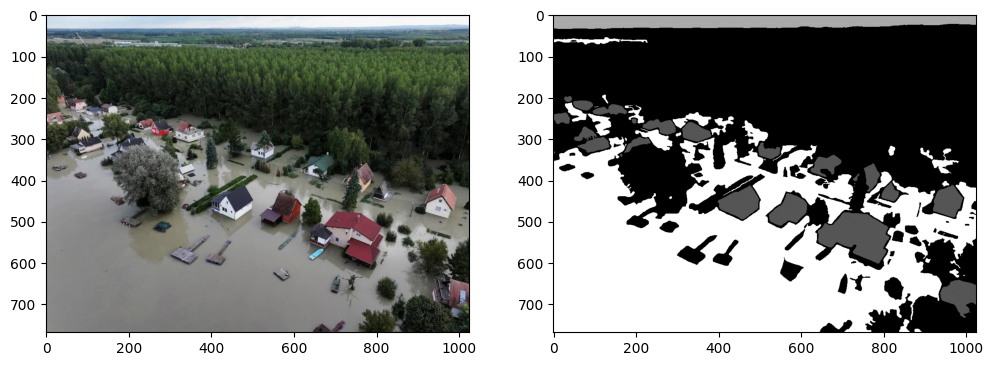

In [7]:
image = Image.open(image_path)
mask = Image.open(mask_path)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [8]:
mask_np = np.array(mask)
np.unique(mask_np)

array([  0,  85, 170, 255], dtype=uint8)

In [9]:
def color_to_index(mask):
    mask_indexes = []

    for color in classes_info['grayscale_value'].values:
        mask_indexes.append(torch.where(mask == color, 1, 0).tolist())

    return torch.tensor(mask_indexes).argmax(dim=0)

In [10]:
color_to_index(torch.tensor(mask_np)).unique()

tensor([0, 1, 2, 3])

In [11]:
IMAGE_SIZE = (448, 448)

train_transforms = A.Compose([
    A.Resize(*IMAGE_SIZE, interpolation=cv2.INTER_NEAREST_EXACT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(*IMAGE_SIZE, interpolation=cv2.INTER_NEAREST_EXACT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

In [12]:
class FloodsDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms):
        super().__init__()
        self.images_pathes = []
        self.masks_pathes = []
        self.transforms = transforms

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)
            mask_name = image_name.split('.')[0] + '.png'
            mask_path = os.path.join(masks_path, mask_name)
            self.images_pathes.append(image_path)
            self.masks_pathes.append(mask_path)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        image_path = self.images_pathes[index]
        mask_path = self.masks_pathes[index]
        image = np.array(Image.open(image_path))
        mask = np.array(Image.open(mask_path))
        transformed = self.transforms(image=image, mask=mask)
        indexed_mask = color_to_index(transformed['mask'].squeeze())
        return transformed['image'], indexed_mask

In [13]:
train_ds = FloodsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, train_transforms)
val_ds = FloodsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH, val_transforms)
len(train_ds), len(val_ds)

(376, 94)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


tensor([0, 1, 2, 3])


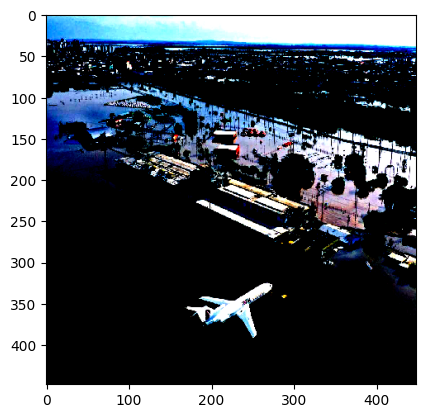

In [14]:
random_index = random.randint(0, len(train_ds) - 1)
random_image = train_ds[random_index][0]
random_mask = train_ds[random_index][1]
print(random_mask.unique())
plt.imshow(random_image.permute(1, 2, 0))


In [15]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
for batch in train_loader:
    images = batch[0]
    image_sample = images[0]
    masks = batch[1]
    mask_sample = masks[0]
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


tensor([0, 1, 3])


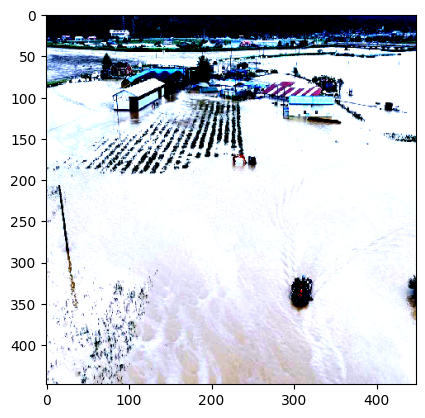

In [17]:
print(mask_sample.unique())
plt.imshow(image_sample.permute(1, 2, 0))

In [18]:
mask_sample.shape

torch.Size([448, 448])

In [19]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [20]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, first_block=False):
        super().__init__()
        if first_block:
            out_channels = 32
        else:
            out_channels = in_channels * 2

        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, batch):
        normalized = self.norm(batch)
        conv1 = self.conv1(normalized)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        return conv2_act

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        in_channels = encoder_channels + decoder_channels
        out_channels = decoder_channels // 2

        self.upconv = nn.ConvTranspose2d(decoder_channels, decoder_channels, 2, 2)
        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, decoder_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(decoder_channels, out_channels, 3, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, encoder, decoder):
        upconved = self.upconv(decoder)
        concatenated = torch.concat([encoder, upconved], dim=1)
        normalized = self.norm(concatenated)
        conv1 = self.conv1(normalized)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        conv3 = self.conv3(conv2_act)
        conv3_act = self.act(conv3)
        return conv3_act

In [22]:
class CustomUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pooling = nn.MaxPool2d(2, 2)
        self.encoder1 = EncoderBlock(3, True)
        self.encoder2 = EncoderBlock(32)
        self.encoder3 = EncoderBlock(64)
        self.encoder4 = EncoderBlock(128)
        self.encoder5 = EncoderBlock(256)
        self.encoder6 = EncoderBlock(512)
        self.decoder1 = DecoderBlock(512, 1024)
        self.decoder2 = DecoderBlock(256, 512)
        self.decoder3 = DecoderBlock(128, 256)
        self.decoder4 = DecoderBlock(64, 128)
        self.decoder5 = DecoderBlock(32, 64)
        self.last_conv = nn.Conv2d(32, num_classes, 1)

    def forward(self, batch):
        encoder1 = self.encoder1(batch)
        encoder1_pool = self.pooling(encoder1)
        encoder2 = self.encoder2(encoder1_pool)
        encoder2_pool = self.pooling(encoder2)
        encoder3 = self.encoder3(encoder2_pool)
        encoder3_pool = self.pooling(encoder3)
        encoder4 = self.encoder4(encoder3_pool)
        encoder4_pool = self.pooling(encoder4)
        encoder5 = self.encoder5(encoder4_pool)
        encoder5_pool = self.pooling(encoder5)
        encoder6 = self.encoder6(encoder5_pool)
        decoder1 = self.decoder1(encoder5, encoder6)
        decoder2 = self.decoder2(encoder4, decoder1)
        decoder3 = self.decoder3(encoder3, decoder2)
        decoder4 = self.decoder4(encoder2, decoder3)
        decoder5 = self.decoder5(encoder1, decoder4)
        output = self.last_conv(decoder5)
        return output

In [23]:
model = CustomUNet(len(classes_info))
model(batch[0]).shape

torch.Size([16, 4, 448, 448])

In [24]:
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder4

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
jaccard_index = JaccardIndex('multiclass', num_classes=len(classes_info)).to(device)

In [26]:
def train(model, loader, loss_fn, optimizer):
    iou_sum = 0
    loss_sum = 0

    model.train()
    for X, Y in tqdm(loader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        iou_sum += jaccard_index(pred, Y).item()
        loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [27]:
def evaluate(model, loader, loss_fn):
    iou_sum = 0
    loss_sum = 0

    model.eval()
    with torch.no_grad():
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            output = model(X)
            loss = loss_fn(output, Y)
            pred = output.argmax(dim=1)
            iou_sum += jaccard_index(pred, Y).item()
            loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [ ]:
EPOCHS = 20
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
min_val_loss = None

for epoch in range(1, EPOCHS + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_iou, train_loss = train(model, train_loader, loss_fn, optimizer)
    train_metrics.append(train_iou)
    train_losses.append(train_loss)
    print(f'Train IoU: {train_iou}')
    print(f'Train loss: {train_loss}')
    val_iou, val_loss = evaluate(model, val_loader, loss_fn)
    val_metrics.append(val_iou)
    val_losses.append(val_loss)
    print(f'Val IoU: {val_iou}')
    print(f'Val loss: {val_loss}')
    lr_scheduler.step(val_loss)

    if not min_val_loss or min_val_loss > val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'models/best_params.pt')
        print('Best model saved')

----------
Epoch 1:


100%|██████████| 24/24 [01:39<00:00,  4.14s/it]


Train IoU: 0.15483713134502372
Train loss: 1.3672275245189667


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Val IoU: 0.1514107882976532
Val loss: 1.3901666204134624
Best model saved
----------
Epoch 2:


100%|██████████| 24/24 [01:35<00:00,  3.99s/it]


Train IoU: 0.31127578889330226
Train loss: 0.8967884803811709


100%|██████████| 6/6 [00:20<00:00,  3.37s/it]


Val IoU: 0.28421760102113086
Val loss: 0.871167908112208
Best model saved
----------
Epoch 3:


100%|██████████| 24/24 [01:35<00:00,  3.99s/it]


Train IoU: 0.3611791456739108
Train loss: 0.6419851432243983


100%|██████████| 6/6 [00:20<00:00,  3.38s/it]


Val IoU: 0.39682180682818097
Val loss: 0.6594804028669993
Best model saved
----------
Epoch 4:


100%|██████████| 24/24 [01:36<00:00,  4.01s/it]


Train IoU: 0.4817825307448705
Train loss: 0.6052795064946016


100%|██████████| 6/6 [00:20<00:00,  3.40s/it]


Val IoU: 0.45858022570610046
Val loss: 0.6854349672794342
----------
Epoch 5:


100%|██████████| 24/24 [01:35<00:00,  3.96s/it]


Train IoU: 0.4777917303144932
Train loss: 0.5654245503246784


100%|██████████| 6/6 [00:20<00:00,  3.39s/it]


Val IoU: 0.4739214976628621
Val loss: 0.627480020125707
Best model saved
----------
Epoch 6:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.5512522707382838
Train loss: 0.5313225165009499


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Val IoU: 0.5573463141918182
Val loss: 0.5825221389532089
Best model saved
----------
Epoch 7:


100%|██████████| 24/24 [01:35<00:00,  3.99s/it]


Train IoU: 0.6114798958102862
Train loss: 0.49251699944337207


100%|██████████| 6/6 [00:20<00:00,  3.38s/it]


Val IoU: 0.6187122960885366
Val loss: 0.5207670629024506
Best model saved
----------
Epoch 8:


100%|██████████| 24/24 [01:35<00:00,  3.99s/it]


Train IoU: 0.6439543589949608
Train loss: 0.45496784150600433


100%|██████████| 6/6 [00:20<00:00,  3.37s/it]


Val IoU: 0.5967222253481547
Val loss: 0.559320405125618
----------
Epoch 9:


100%|██████████| 24/24 [01:35<00:00,  4.00s/it]


Train IoU: 0.6471053759256998
Train loss: 0.44798365980386734


100%|██████████| 6/6 [00:20<00:00,  3.39s/it]


Val IoU: 0.6419747869173685
Val loss: 0.4939352671305339
Best model saved
----------
Epoch 10:


100%|██████████| 24/24 [01:34<00:00,  3.95s/it]


Train IoU: 0.6774349361658096
Train loss: 0.42076000571250916


100%|██████████| 6/6 [00:19<00:00,  3.32s/it]


Val IoU: 0.6314769784609476
Val loss: 0.5195190558830897
----------
Epoch 11:


100%|██████████| 24/24 [01:33<00:00,  3.88s/it]


Train IoU: 0.6752941707770029
Train loss: 0.40889829273025197


100%|██████████| 6/6 [00:19<00:00,  3.25s/it]


Val IoU: 0.629880448182424
Val loss: 0.4860059916973114
Best model saved
----------
Epoch 12:


100%|██████████| 24/24 [01:32<00:00,  3.87s/it]


Train IoU: 0.6778772845864296
Train loss: 0.4064493204156558


100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


Val IoU: 0.6264018217722574
Val loss: 0.5208164801200231
----------
Epoch 13:


100%|██████████| 24/24 [01:35<00:00,  3.97s/it]


Train IoU: 0.6733894546826681
Train loss: 0.4111691700915496


100%|██████████| 6/6 [00:19<00:00,  3.33s/it]


Val IoU: 0.6571560502052307
Val loss: 0.5018304536739985
----------
Epoch 14:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.6947763413190842
Train loss: 0.3857543542981148


100%|██████████| 6/6 [00:20<00:00,  3.36s/it]


Val IoU: 0.6657069524129232
Val loss: 0.4668143093585968
Best model saved
----------
Epoch 15:


100%|██████████| 24/24 [01:34<00:00,  3.95s/it]


Train IoU: 0.7033277625838915
Train loss: 0.36740447704990703


100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


Val IoU: 0.6747581462065378
Val loss: 0.4570062806208928
Best model saved
----------
Epoch 16:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.7073577269911766
Train loss: 0.3698439175883929


100%|██████████| 6/6 [00:20<00:00,  3.36s/it]


Val IoU: 0.6618079642454783
Val loss: 0.4789932618538539
----------
Epoch 17:


100%|██████████| 24/24 [01:34<00:00,  3.93s/it]


Train IoU: 0.7009437183539072
Train loss: 0.37309986477096874


100%|██████████| 6/6 [00:19<00:00,  3.31s/it]


Val IoU: 0.6181461612383524
Val loss: 0.4834813674290975
----------
Epoch 18:


100%|██████████| 24/24 [01:34<00:00,  3.95s/it]


Train IoU: 0.7117288385828336
Train loss: 0.3689617154498895


100%|██████████| 6/6 [00:20<00:00,  3.35s/it]


Val IoU: 0.6592131654421488
Val loss: 0.4860697438319524
----------
Epoch 19:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.7187251523137093
Train loss: 0.34460606550176937


100%|██████████| 6/6 [00:20<00:00,  3.35s/it]


Val IoU: 0.6862397690614065
Val loss: 0.4320288995901744
Best model saved
----------
Epoch 20:


100%|██████████| 24/24 [01:36<00:00,  4.00s/it]


Train IoU: 0.7294876351952553
Train loss: 0.33242678207655746


100%|██████████| 6/6 [00:19<00:00,  3.32s/it]

Val IoU: 0.688422958056132
Val loss: 0.43523435294628143


In [29]:
lr_scheduler.get_last_lr()

[1e-05]

Text(0.5, 1.0, "IoU's")

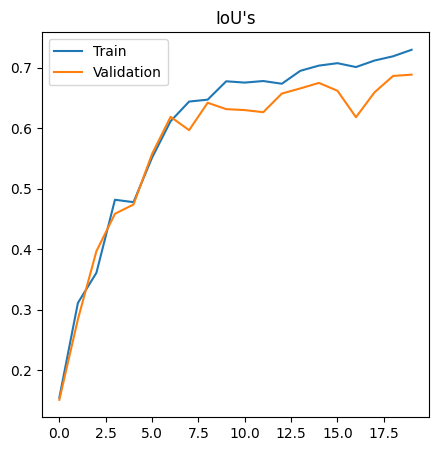

In [30]:
plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='Train')
plt.plot(val_metrics, label='Validation')
plt.legend()
plt.title('IoU\'s')

Text(0.5, 1.0, 'Losses')

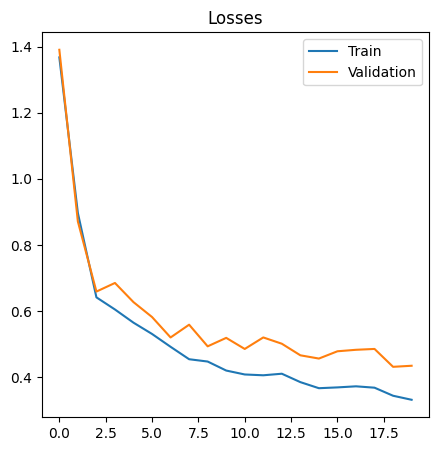

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')

In [32]:
model = CustomUNet(len(classes_info))
model.load_state_dict(torch.load('models/best_params.pt', weights_only=True))
model.eval()
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder4

In [33]:
def index_to_color(mask):
    mask_colors = []

    for index in range(len(classes_info)):
        color = classes_info[classes_info['class_index'] == index]['grayscale_value'].item()
        mask_colors.append(torch.where(mask == index, color, 0).tolist())

    return torch.tensor(mask_colors).max(dim=0).values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.6399999].


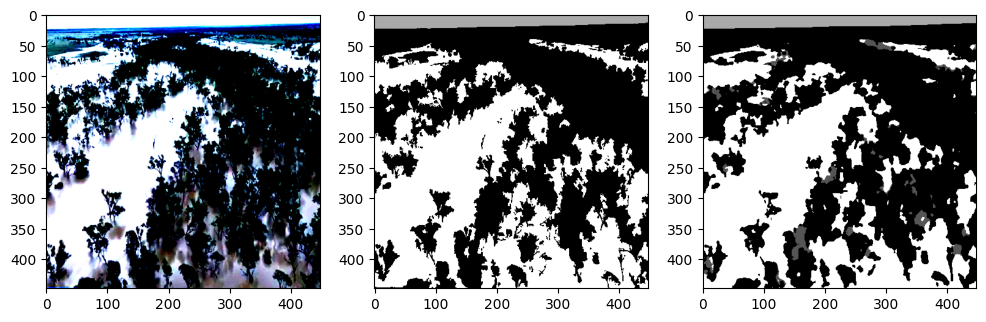

In [34]:
test_index = random.randint(0, len(val_ds) - 1)
test_image = val_ds[test_index][0]
test_mask = val_ds[test_index][1]
test_pred = model(test_image.unsqueeze(0).to(device))[0].argmax(dim=0)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(index_to_color(test_mask), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(index_to_color(test_pred), cmap='gray')